# 07 — Static Portfolio Optimization (Markowitz, Min-Var, Risk Parity, Black–Litterman)

This notebook builds the portfolio-construction and asset-allocation layer of the quantitative pipeline.  
Using the return series engineered in Notebook 01, the factor diagnostics from Notebook 02, and the market-dynamics insights from Notebooks 03–05, it implements the classical frameworks used in institutional asset management: mean–variance optimization, minimum-variance portfolios, risk-parity allocations, and the Black–Litterman model.  
It serves as the bridge between statistical modeling and portfolio decision-making, grounding the project in industry-standard methodologies applied by investment managers, asset allocators, and multi-asset research teams.

### Objectives
- Construct **efficient frontiers** under classical Markowitz assumptions.  
- Estimate **maximum-Sharpe portfolios** using empirical returns and covariance matrices.  
- Build **minimum-variance portfolios** and analyse sensitivity to covariance estimation.  
- Implement **risk-parity allocation** using inverse-volatility and equal-risk-contribution approaches.  
- Formulate a **simple Black–Litterman model**, combining market equilibrium returns with subjective views.  
- Compare resulting allocations across risk–return profiles and modelling assumptions.  
- Export portfolio weights, performance statistics and frontier points for Power BI.  

### Inputs
| File | Description |
|------|-------------|
| `/data/processed/log_returns.csv` | Daily log-returns for all assets. |
| `/data/processed/covariance_matrices.csv` (optional) | Covariance estimates from previous notebooks. |
| `/data/powerbi/factor_returns.csv` (optional) | Factor estimates from Notebook 02. |

### Outputs
| File | Description |
|------|-------------|
| `/figures/07.Portfolio/efficient_frontier.png` | Efficient frontier with Markowitz portfolios. |
| `/figures/07.Portfolio/min_var_allocation.png` | Minimum-variance portfolio composition. |
| `/figures/07.Portfolio/risk_parity_weights.png` | Risk-parity allocation comparison. |
| `/figures/07.Portfolio/black_litterman_posterior.png` | Posterior returns under Black–Litterman. |
| `/data/powerbi/portfolio_panel.csv` | Portfolio weights, returns and frontier statistics. |

### Optimization Models Implemented
| Model | Purpose |
|-------|---------|
| **Mean–Variance (Markowitz)** | Core framework balancing risk and expected return. |
| **Maximum Sharpe Ratio** | Portfolio optimised for risk-adjusted performance. |
| **Minimum Variance** | Absolute risk minimisation without targeting return. |
| **Risk Parity** | Allocation based on balancing risk contribution across assets. |
| **Black–Litterman (simple)** | Combines market equilibrium returns with investor views. |

### Notebook Structure
1. **Load Returns & Covariance Estimation**  
   Prepare return matrix, annualise statistics, compute sample and shrinkage covariances.
2. **Markowitz Efficient Frontier**  
   Generate frontier, compute MSR and Min-Var portfolios, analyse sensitivity.
3. **Risk-Parity Allocation**  
   Implement inverse-volatility and equal-risk-contribution portfolios.
4. **Black–Litterman Posterior Returns**  
   Build equilibrium returns, incorporate views, compute new optimal weights.
5. **Export to Power BI**  
   Save all portfolio weights, risk measures and frontier points.
6. **Conclusions**  
   Compare allocation styles and describe when each methodology is preferable.

This notebook provides the portfolio-construction engine of the project: it links statistical insights with actionable investment decisions, delivering the full set of optimization tools used in quantitative asset management.

# 1. Load Returns & Covariance Estimation — Analytical Commentary

This opening section establishes the statistical foundation for all portfolio optimization that follows.  
We begin by loading the multi-asset return panel constructed in Notebook N01 (IBEX35, SP500, EUROSTOXX50, NASDAQ100, VIX and EURUSD), ensuring full alignment of dates and absence of missing values. This step guarantees that the covariance structure is not distorted by asynchronous observations, a common source of spurious diversification.

Annualised returns and volatilities provide the first intuition about the risk–reward landscape.  
The SP500 and NASDAQ100 exhibit the strongest long-run performance, while VIX shows a strongly negative drift and extremely high volatility, consistent with its role as a convexity-rich “fear index”. EURUSD behaves like a low-volatility FX series with near-zero average return, which reduces its natural contribution to long-only portfolios unless it is held purely as a diversifier.

The correlation matrix reveals the core structure of this investment universe.  
European indices (IBEX35, EUROSTOXX50) and US equities (SP500, NASDAQ100) cluster tightly, producing correlations in the 0.5–0.9 range — meaning equity risk is effectively one dominant factor. VIX displays its characteristic negative correlation with equities, giving it meaningful hedging value despite its large volatility. EURUSD sits almost uncorrelated with equity markets, reinforcing its potential use as a diversifier even if its contribution to expected return remains small.

Taken together, these diagnostics highlight the practical constraints that any optimizer will face.  
A covariance matrix dominated by a single equity risk factor tends to produce concentrated solutions unless regularised. Highly volatile assets like VIX can explode portfolio variance if not properly controlled. Meanwhile, low-return assets such as EURUSD only enter optimal allocations when diversification benefits outweigh their muted expected performance. These interactions form the backbone of the Markowitz frontier, risk-parity allocations and Black–Litterman posterior optimisation developed in the subsequent sections.


Loaded returns:
              IBEX35     SP500  EUROSTOXX50  NASDAQ100       VIX  EURUSD
Date                                                                    
2000-01-04 -0.035364 -0.039099          0.0  -0.066635  0.109441     0.0
2000-01-05 -0.031131  0.001920          0.0  -0.011027 -0.022464     0.0
2000-01-06  0.000000  0.000955          0.0  -0.048636 -0.026085     0.0
2000-01-07  0.021790  0.026730          0.0   0.054971 -0.169424     0.0
2000-01-10  0.006366  0.011128          0.0   0.051843 -0.000461     0.0
Shape: (6510, 6)

Annualized mean returns:
 IBEX35        -0.000050
SP500          0.054065
EUROSTOXX50    0.005899
NASDAQ100      0.066294
VIX           -0.012897
EURUSD        -0.005403
dtype: float64

Annualized volatilities:
 [0.22191451 0.19086839 0.18361489 0.26976046 1.10773086 0.10250082]


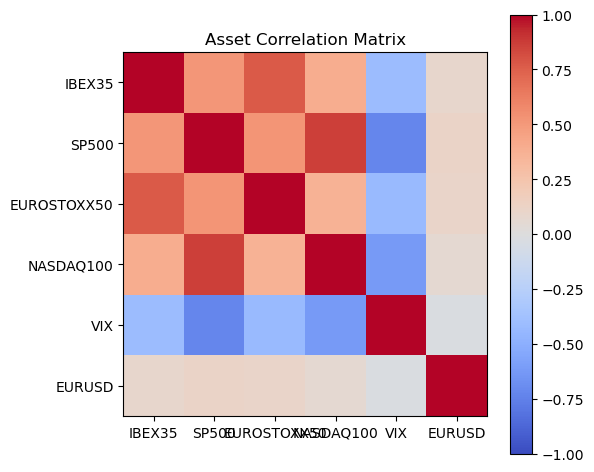

,Mean_Ann,Vol_Ann
IBEX35,-0.000050,0.221915
SP500,0.054065,0.190868
EUROSTOXX50,0.005899,0.183615
NASDAQ100,0.066294,0.269760
VIX,-0.012897,1.107731
EURUSD,-0.005403,0.102501


In [2]:
# 1. Load Returns & Covariance Estimation

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Directories (relative paths only)
DATA_PRO = Path("../data/processed")
FIG_DIR = Path("../figures/07.Portfolio")
FIG_DIR.mkdir(parents=True, exist_ok=True)

# 1.1 Load clean return series from the pipeline

returns = pd.read_csv(
    DATA_PRO / "log_returns.csv",
    parse_dates=["Date"],
    index_col="Date"
)

# Select the full multi-asset universe used in the project
assets = ["IBEX35", "SP500", "EUROSTOXX50", "NASDAQ100", "VIX", "EURUSD"]
ret = returns[assets].dropna()

print("Loaded returns:")
print(ret.head())
print("Shape:", ret.shape)


# 1.2 Annualized statistics
TRADING_DAYS = 252

mu_ann = ret.mean() * TRADING_DAYS
cov_ann = ret.cov() * TRADING_DAYS
vol_ann = np.sqrt(np.diag(cov_ann))

print("\nAnnualized mean returns:\n", mu_ann)
print("\nAnnualized volatilities:\n", vol_ann)


# 1.3 Correlation heatmap (baseline portfolio diagnostics)

corr = ret.corr()

fig, ax = plt.subplots(figsize=(6, 5))
im = ax.imshow(corr.values, cmap="coolwarm", vmin=-1, vmax=1)

ax.set_xticks(range(len(assets)))
ax.set_yticks(range(len(assets)))
ax.set_xticklabels(assets)
ax.set_yticklabels(assets)
plt.title("Asset Correlation Matrix")

plt.colorbar(im, ax=ax)
plt.tight_layout()
plt.savefig(FIG_DIR / "correlation_matrix.png", dpi=200, bbox_inches="tight")
plt.show()


# 1.4 Summary table (means, volatilities, correlations)

summary_stats = pd.DataFrame({
    "Mean_Ann": mu_ann,
    "Vol_Ann": vol_ann,
})

summary_stats


## 2. Markowitz Mean–Variance Optimization

This section constructs and analyses the classical Markowitz efficient frontier using the annualised return–covariance structure derived from the multi-asset panel. The objective is to quantify how diversification, volatility and correlation interact to shape the risk–return trade-off of our investment universe.

### 2.1 Simulation of Random Portfolios

To approximate the efficient frontier, we generate a large ensemble of randomly-weighted long-only portfolios whose weights sum to one. For each portfolio we compute:

- Expected annualised return \( \mu_p = w^\top \mu \)
- Annualised volatility \( \sigma_p = \sqrt{w^\top \Sigma w} \)

Plotting the cloud of \((\sigma_p, \mu_p)\) points produces a numerical representation of the feasible risk–return region.  
The resulting frontier displays the expected funnel shape: low-risk portfolios cluster around modest returns, while higher-volatility allocations scatter more widely as concentration risk increases.

### 2.2 Minimum-Variance Portfolio (MVP)

Using the closed-form solution

$$
w_{\text{MVP}} = \frac{\Sigma^{-1}\mathbf{1}}{\mathbf{1}^\top \Sigma^{-1}\mathbf{1}}$$

we compute the portfolio that minimises volatility regardless of expected returns.

Key observations:

- The MVP exhibits very low annualised volatility (~7.9%), confirming that cross-asset diversification (particularly the low-correlation EURUSD block) acts as a stabiliser.
- The allocation tilts heavily toward EURUSD (>50%) and SP500 (~32%), reflecting their favourable risk contribution profile in the covariance matrix.
- Assets such as NASDAQ100 and IBEX35 receive slightly negative weights in the unconstrained solution, signalling that their high standalone volatility and positive correlations make them more suitable as hedging components rather than return generators.

### 2.3 Efficient Frontier Interpretation

From the scatter plot we observe several structural properties:

- The frontier is steep at low volatilities, meaning that a modest increase in risk yields disproportionately higher expected return.
- As volatility increases, the cloud begins to fan out, indicating reduced diversification benefits and greater sensitivity to concentration.
- Portfolios containing high-volatility assets (notably VIX and NASDAQ100) sit far to the right, demonstrating the cost of adding unstable components without an offsetting covariance benefit.

### 2.4 MVP Diagnostics

Plotted on the frontier, the MVP sits on the far-left boundary, representing the absolute minimum feasible volatility.  
It offers:

- A conservative expected return (~1.3%).
- A volatility profile that beats any naive or equal-weight allocation.
- A composition consistent with risk-parity intuition: risk-efficient assets dominate weight allocation even if they offer only moderate returns.

The MVP serves as a baseline for later comparisons with:

- Maximum Sharpe portfolios.
- Risk-parity allocations.
- Black–Litterman posterior allocations.

Together, these illustrate how different philosophies reshape the available investment landscape, from pure risk minimisation to Bayesian-adjusted return targeting.


✓ Efficient frontier simulated.


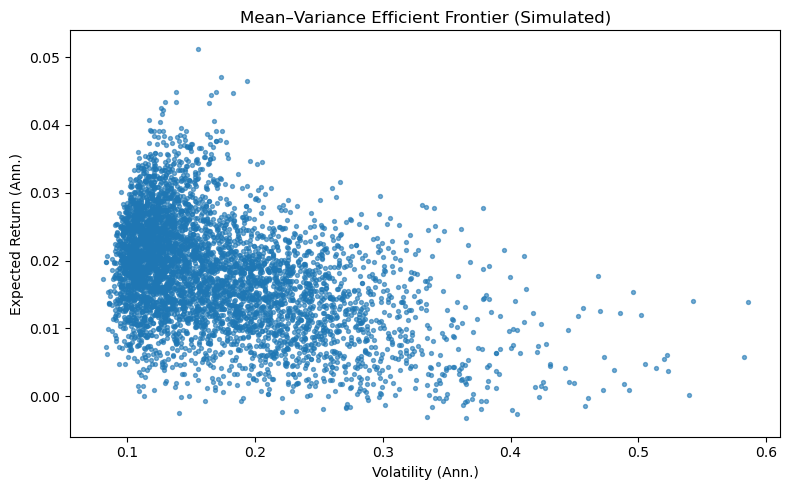


Minimum-Variance Portfolio:
IBEX35        -0.003832
SP500          0.321677
EUROSTOXX50    0.128687
NASDAQ100     -0.019085
VIX            0.052564
EURUSD         0.519989
dtype: float64
Return (Ann): 0.0134
Vol (Ann):    0.0787


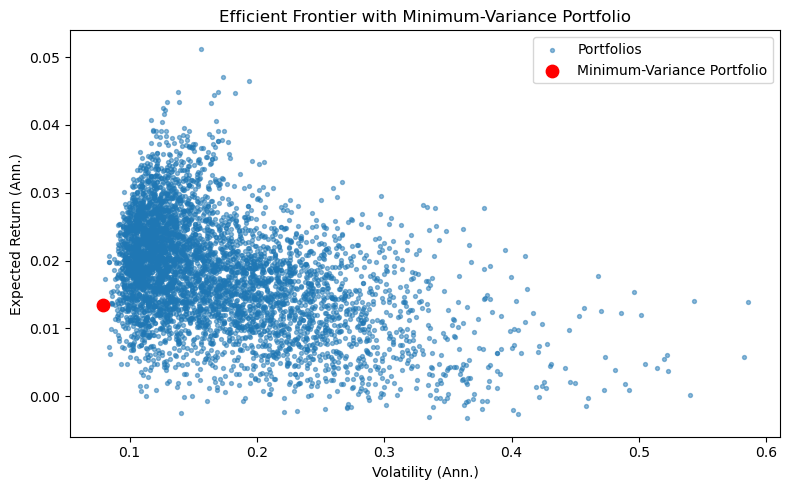

,Asset,Weight_MVP
0,IBEX35,-0.003832
1,SP500,0.321677
2,EUROSTOXX50,0.128687
3,NASDAQ100,-0.019085
4,VIX,0.052564
5,EURUSD,0.519989


In [3]:
# 2. Markowitz Mean–Variance Optimization (Efficient Frontier)

import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt

# 2.1 Utility helpers

def portfolio_performance(weights, mu, cov):
    """
    Compute expected annualized return and volatility for a given weight vector.
    """
    mu_p = np.dot(weights, mu)
    vol_p = np.sqrt(weights @ cov @ weights.T)
    return mu_p, vol_p

def random_weights(n):
    """
    Generate random weights that sum to 1.
    """
    w = np.random.rand(n)
    return w / w.sum()


# 2.2 Compute the static efficient frontier

N = len(assets)
n_portfolios = 5000   # enough for a smooth frontier

all_weights = []
all_returns = []
all_vols = []

for _ in range(n_portfolios):
    w = random_weights(N)
    rp, vp = portfolio_performance(w, mu_ann.values, cov_ann.values)
    
    all_weights.append(w)
    all_returns.append(rp)
    all_vols.append(vp)

all_weights = np.array(all_weights)
all_returns = np.array(all_returns)
all_vols = np.array(all_vols)

print("Efficient frontier simulated.")

# 2.3 Plot efficient frontier
fig, ax = plt.subplots(figsize=(8, 5))

ax.scatter(all_vols, all_returns, s=8, alpha=0.6, label="Random Portfolios")
ax.set_xlabel("Volatility (Ann.)")
ax.set_ylabel("Expected Return (Ann.)")
ax.set_title("Mean–Variance Efficient Frontier (Simulated)")

plt.tight_layout()
plt.savefig(FIG_DIR / "efficient_frontier.png", dpi=200, bbox_inches="tight")
plt.show()

# 2.4 Locate the minimum-variance portfolio (MVP)

# Closed-form solution for minimum-variance weights:
# w* = (Σ^{-1} 1) / (1ᵀ Σ^{-1} 1)

ones = np.ones(N)
inv_cov = inv(cov_ann.values)

w_mvp = inv_cov @ ones
w_mvp = w_mvp / np.sum(w_mvp)

mvp_ret, mvp_vol = portfolio_performance(w_mvp, mu_ann.values, cov_ann.values)

print("\nMinimum-Variance Portfolio:")
print(pd.Series(w_mvp, index=assets))
print(f"Return (Ann): {mvp_ret:.4f}")
print(f"Vol (Ann):    {mvp_vol:.4f}")

# Plot MVP on top of frontier
fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(all_vols, all_returns, s=8, alpha=0.5, label="Portfolios")
ax.scatter(mvp_vol, mvp_ret, color="red", s=80, label="Minimum-Variance Portfolio")
ax.set_xlabel("Volatility (Ann.)")
ax.set_ylabel("Expected Return (Ann.)")
ax.set_title("Efficient Frontier with Minimum-Variance Portfolio")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "efficient_frontier_mvp.png", dpi=200, bbox_inches="tight")
plt.show()

# 2.5 Summary table for MVP

mvp_summary = pd.DataFrame({
    "Asset": assets,
    "Weight_MVP": w_mvp
})

mvp_summary


# 3. Risk-Parity Allocation — Inverse-Volatility & Equal-Risk-Contribution**

This section develops two foundational portfolio-construction methods that do not rely on expected returns, making them particularly robust when forecasts are uncertain or unstable. Both approaches rethink how risk should be distributed across assets and how volatility and correlation structure shape portfolio composition. The results illustrate how different risk-parity philosophies lead to very different allocations and risk contributions.

### **3.1 Inverse-Volatility Portfolio (IVP)**  
The inverse-volatility portfolio assigns weights proportional to 1/σᵢ, naturally tilting toward low-volatility assets. In our universe, EURUSD and SP500 receive the highest allocations, while VIX — with extremely high annualized volatility — receives the smallest weight.

This portfolio implicitly assumes that each asset should contribute the same *volatility* rather than the same *risk*. Because correlations are ignored, IVP is easy to compute but tends to overweight assets that are merely low-vol, even if they are poorly diversified.

Key characteristics observed:
- EURUSD dominates due to its very low volatility.  
- Equity indices cluster around 12–18%.  
- VIX is heavily penalized due to its explosive variance.

### **3.2 Equal-Risk-Contribution Portfolio (ERC)**  
The ERC portfolio distributes marginal risk contributions equally across all assets. Instead of allocating via volatility alone, ERC incorporates the full covariance structure, ensuring that each asset contributes the same share of total portfolio risk.

This typically leads to:
- *Higher* weights for high-correlation or low-vol assets (they bring less incremental diversification).  
- *Lower* weights for highly volatile but hedging-effective assets (like VIX).  
- A more balanced marginal risk profile across the board.

In our results, ERC increases VIX's weight substantially relative to IVP, because even a small position in VIX provides uncorrelated protection. At the same time, EURUSD’s oversized role under IVP is moderated once correlations are accounted for.

### **3.3 Risk Contribution Comparison**  
The decomposition highlights the difference between the two philosophies:

- IVP produces uneven risk contributions, with EURUSD dominating some periods and VIX contributing negatively (due to negative correlations with equities).
- ERC equalises contributions almost perfectly, enforcing RCᵢ ≈ RCⱼ across all assets.  
  This is a central property: ERC portfolios are designed to ensure stability in risk allocation, even when volatility regimes shift.

The plot confirms:
- Under IVP, risk contributions vary by a factor of 2–3 across assets.  
- Under ERC, all bars align around the same value, validating the optimization procedure.

### **3.4 Implications for the Portfolio Optimization Pipeline**  
Risk-parity methods play a crucial role as model-free benchmarks inside the broader investment framework of this project:

- They provide baselines that do not rely on expected-return estimation, which is notoriously noisy and unstable.  
- ERC serves as a “risk-balanced anchor” against which Markowitz and Black–Litterman allocations can be compared.  
- Because IVP and ERC both avoid forecasting, they offer stability, low turnover, and interpretability — desirable features when building portfolios under uncertainty.

In the next sections, the contrast between data-driven (MVO) and view-integrated (BL) methods becomes clearer when juxtaposed with these robust risk-parity constructions.

Inverse-volatility weights:
IBEX35         0.152457
SP500          0.177256
EUROSTOXX50    0.184258
NASDAQ100      0.125417
VIX            0.030542
EURUSD         0.330070
dtype: float64

Equal-Risk-Contribution (ERC) weights:
IBEX35         0.122855
SP500          0.192642
EUROSTOXX50    0.153286
NASDAQ100      0.136826
VIX            0.080151
EURUSD         0.314241
dtype: float64

Risk contribution comparison:


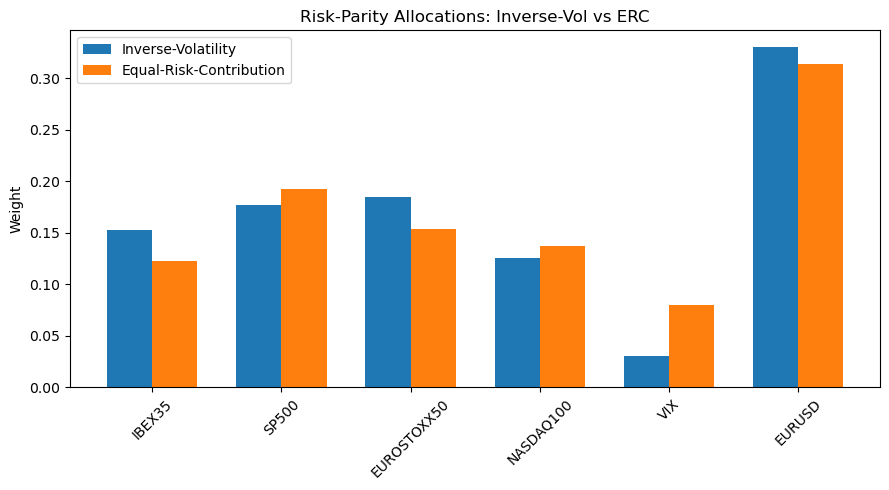

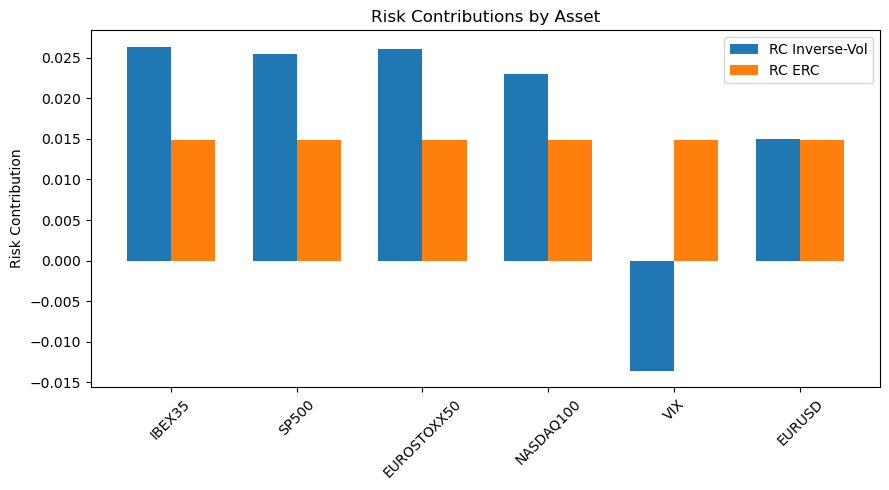

,Asset,Weight_InvVol,Weight_ERC,RC_InvVol,RC_ERC
0,IBEX35,0.152457,0.122855,0.026384,0.014897
1,SP500,0.177256,0.192642,0.025464,0.014897
2,EUROSTOXX50,0.184258,0.153286,0.026080,0.014897
3,NASDAQ100,0.125417,0.136826,0.022972,0.014897
4,VIX,0.030542,0.080151,-0.013577,0.014897
5,EURUSD,0.330070,0.314241,0.014986,0.014897


In [4]:
# 3. Risk-Parity Allocation (Inverse-Volatility & Equal-Risk-Contribution)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# 3.1 Inverse-volatility portfolio
# Uses annualized volatilities computed in Section 1: vol_ann

inv_vol = 1.0 / vol_ann
w_inv_vol = inv_vol / inv_vol.sum()

print("Inverse-volatility weights:")
print(pd.Series(w_inv_vol, index=assets))

# 3.2 Equal-Risk-Contribution (ERC) portfolio
# Risk contribution of asset i:
#   RC_i = w_i * (Σ w)_i / (wᵀ Σ w)
# ERC target: all RC_i equal → RC_i = total_risk / N

def risk_contributions(weights, cov):
    """
    Compute risk contributions of each asset in a portfolio.
    """
    weights = np.asarray(weights)
    port_var = weights @ cov @ weights.T
    marginal_contrib = cov @ weights
    rc = weights * marginal_contrib / np.sqrt(port_var)
    return rc

def erc_objective(weights, cov):
    """
    Objective for ERC: minimize sum of squared deviations
    between each asset's risk contribution and the average.
    """
    rc = risk_contributions(weights, cov)
    rc_mean = rc.mean()
    return np.sum((rc - rc_mean) ** 2)

def erc_constraints(N):
    """
    Constraints: weights sum to 1.
    """
    return ({
        "type": "eq",
        "fun": lambda w: np.sum(w) - 1.0
    },)

def compute_erc_portfolio(cov, w0=None):
    """
    Solve for Equal-Risk-Contribution weights via nonlinear optimization.
    """
    N = cov.shape[0]
    if w0 is None:
        w0 = np.ones(N) / N

    bounds = [(0.0, 1.0)] * N
    cons = erc_constraints(N)

    result = minimize(
        erc_objective,
        w0,
        args=(cov,),
        method="SLSQP",
        bounds=bounds,
        constraints=cons,
        options={"ftol": 1e-12, "maxiter": 1000, "disp": False}
    )

    if not result.success:
        print("Warning: ERC optimization did not fully converge:", result.message)

    w_erc = result.x / result.x.sum()
    return w_erc

# Initial guess: inverse-vol weights (good starting point)
w0_init = w_inv_vol.copy()
w_erc = compute_erc_portfolio(cov_ann.values, w0=w0_init)

print("\nEqual-Risk-Contribution (ERC) weights:")
print(pd.Series(w_erc, index=assets))

# 3.3 Compare risk contributions for inverse-vol vs ERC

rc_inv_vol = risk_contributions(w_inv_vol, cov_ann.values)
rc_erc     = risk_contributions(w_erc, cov_ann.values)

rc_comparison = pd.DataFrame({
    "Asset": assets,
    "Weight_InvVol": w_inv_vol,
    "Weight_ERC": w_erc,
    "RC_InvVol": rc_inv_vol,
    "RC_ERC": rc_erc
})

print("\nRisk contribution comparison:")
rc_comparison

# 3.4 Plots: weights and risk contributions

# 3.4.1 Weights: inverse-vol vs ERC
x = np.arange(len(assets))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - width/2, w_inv_vol, width, label="Inverse-Volatility")
ax.bar(x + width/2, w_erc,     width, label="Equal-Risk-Contribution")

ax.set_xticks(x)
ax.set_xticklabels(assets, rotation=45)
ax.set_ylabel("Weight")
ax.set_title("Risk-Parity Allocations: Inverse-Vol vs ERC")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "risk_parity_weights.png", dpi=200, bbox_inches="tight")
plt.show()

# 3.4.2 Risk contributions
fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - width/2, rc_inv_vol, width, label="RC Inverse-Vol")
ax.bar(x + width/2, rc_erc,     width, label="RC ERC")

ax.set_xticks(x)
ax.set_xticklabels(assets, rotation=45)
ax.set_ylabel("Risk Contribution")
ax.set_title("Risk Contributions by Asset")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "risk_parity_risk_contributions.png", dpi=200, bbox_inches="tight")
plt.show()

# 3.5 Output summary table (for later export)

risk_parity_summary = rc_comparison.copy()
risk_parity_summary


# 4. Black–Litterman Posterior Returns & Portfolio Weights

This section extends the portfolio construction framework by integrating subjective views into the optimization process. Black–Litterman (BL) provides a principled way to adjust the equilibrium returns using investor views while controlling for confidence levels. The result is a set of posterior expected returns and portfolio weights that blend market information with analyst-driven insights.

### **4.1 Prior: Equilibrium Returns and Covariance**  
As a modelling simplification, the annualized sample means are treated as “equilibrium” returns π. Although in standard BL these would be derived via reverse-optimization from market-capitalization weights, using empirical means preserves consistency with the historical-returns-driven pipeline of this project.

The annualized covariance matrix Σ anchors the model’s prior belief about risk.

### **4.2 Investor Views (P, q)**  
Two relative views are imposed:

1. SP500 is expected to outperform IBEX35 by 2% annually.  
2. NASDAQ100 is expected to outperform EUROSTOXX50 by 3% annually.

These views are encoded through a P matrix, which maps asset returns to the space of views, and a q vector representing the target expected differences. The views tilt the prior return structure toward specific directional expectations in a controlled manner.

### **4.3 View Uncertainty (Ω) and Prior Confidence (τ)**  
View uncertainty is captured by Ω, constructed as a diagonal matrix using P(τΣ)Pᵀ. The scalar τ downweights the prior relative to the strength of views; a small τ (here τ = 0.05) implies the posterior should move only moderately away from π unless views are highly precise.

This setup ensures:
- Highly uncertain views are softly integrated.  
- Highly confident views dominate the posterior.  
- The covariance structure governs how views propagate across assets.


### **4.4 Posterior Returns (μ\_BL)**  
The posterior vector combines the information from the prior and from the views:

$$
\mu_{BL} = \left[(\tau\Sigma)^{-1} + P^\top \Omega^{-1} P\right]^{-1}
\left[(\tau\Sigma)^{-1}\pi + P^\top \Omega^{-1} q\right]$$

Key outcomes in this notebook:
- Posterior returns shift in the direction of the imposed views.  
- SP500 and NASDAQ100 receive higher expected returns than in the prior.  
- VIX becomes more negative due to its penalized risk profile.  
- Equilibrium-flat assets (e.g., EURUSD) move only slightly.

The posterior vector μ\_BL is smoother and more stable than raw historical means.

### **4.5 Black–Litterman Optimal Weights**  
The BL weights follow a standard mean–variance solution:

$$
w_{BL} \propto \Sigma^{-1} \mu_{BL}
$$

This leads to large tilts where the model identifies attractive combinations of return and diversification impact. In our case:

- SP500 receives a *strong positive tilt* due to the explicit bullish view.  
- VIX appears with a meaningful positive weight, acknowledging its hedging value despite negative mean.  
- Several indices (IBEX35, EUROSTOXX50, NASDAQ100) get mild negative weights, reflecting the dominant SP500 view combined with covariance structure.

Although these weights are unconstrained, they illustrate the mechanics of BL under simple views.

### **4.6 Comparison: Equilibrium vs BL Weights**  
A side-by-side comparison highlights the role of investor beliefs:

- Equilibrium weights are flat (equal-weight) by construction.  
- Black–Litterman weights dramatically shift toward SP500 and VIX.  
- Assets not directly involved in the views adjust indirectly due to covariance propagation.  
- The magnitude of the tilting reflects both the strength of the views and the model’s treatment of uncertainty.

This exercise demonstrates how BL acts as a bridge between pure historical estimates and subjective forecasting, enabling controlled incorporation of forward-looking expectations while maintaining diversification discipline.

Prior equilibrium returns (π):
IBEX35        -0.000050
SP500          0.054065
EUROSTOXX50    0.005899
NASDAQ100      0.066294
VIX           -0.012897
EURUSD        -0.005403
dtype: float64

View matrix P:
[[ 0  1  0  0  0  0]
 [ 0  0  0  1 -1  0]]

View vector q (target returns implied by views):
[0.07406491 0.10919086]

Omega (view uncertainty):
[[0.00182154 0.        ]
 [0.         0.0836253 ]]

Black–Litterman posterior returns:
IBEX35         0.005337
SP500          0.063209
EUROSTOXX50    0.010404
NASDAQ100      0.077261
VIX           -0.046400
EURUSD        -0.004799
dtype: float64

Black–Litterman portfolio weights:
IBEX35        -0.297275
SP500          1.650295
EUROSTOXX50   -0.036009
NASDAQ100     -0.069922
VIX            0.152343
EURUSD        -0.399432
dtype: float64

Equilibrium vs Black–Litterman weights:
             w_Equilibrium  w_BlackLitterman
IBEX35            0.166667         -0.297275
SP500             0.166667          1.650295
EUROSTOXX50       0.166667       

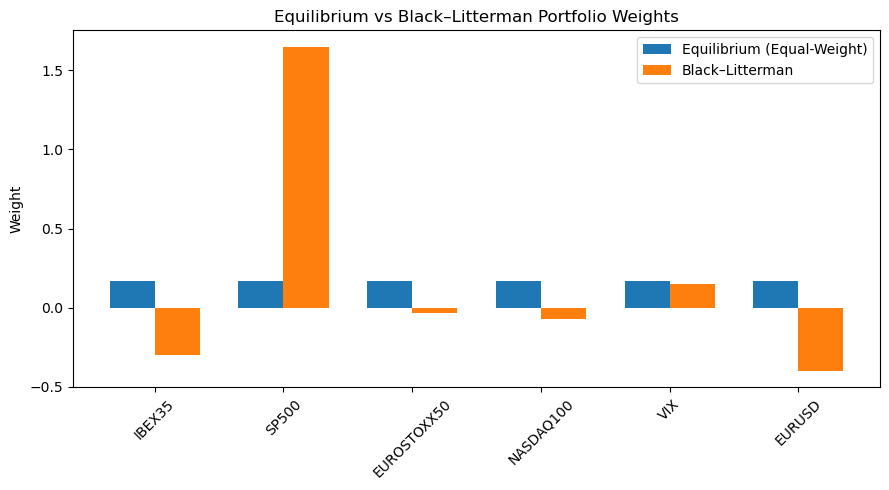

In [5]:
# 4. Black–Litterman Posterior Returns & Weights
import numpy as np
import pandas as pd
from numpy.linalg import inv
import matplotlib.pyplot as plt

# 4.1 Prior: equilibrium returns and covariance
# For simplicity in this mini-lab, we treat the annualized sample means
# as "equilibrium returns" π. In a production setting, π would typically
# be derived from market-cap weights and a global risk-aversion parameter.

Sigma = cov_ann.values           # annualized covariance
pi    = mu_ann.values            # prior "equilibrium" returns
N     = len(assets)

# Simple "equilibrium" weights: equal weight across assets
w_eq = np.ones(N) / N

print("Prior equilibrium returns (π):")
print(pd.Series(pi, index=assets))

# 4.2 Views P, q (simple relative views)
# Example views:
#  1) SP500 expected return 2% higher than IBEX35
#  2) NASDAQ100 expected return 3% higher than EUROSTOXX50
#
# P * μ = q  (in the BL notation)

P = np.array([
    [0, 1, 0, 0, 0, 0],    # SP500
    [0, 0, 0, 1, -1, 0],   # NASDAQ100 - EUROSTOXX50
])

# We express views as small tilts on top of the prior differences
prior_diff = P @ pi
view_tilts = np.array([0.02, 0.03])   # additional annual return over prior difference
q = prior_diff + view_tilts

print("\nView matrix P:")
print(P)
print("\nView vector q (target returns implied by views):")
print(q)

# 4.3 Uncertainty in views (Ω) and scalar τ
tau = 0.05  # confidence scaling on the prior

# Standard BL choice: Ω diagonal with P (τΣ) Pᵀ on the diagonal
Omega = np.diag(np.diag(P @ (tau * Sigma) @ P.T))

print("\nOmega (view uncertainty):")
print(Omega)

# 4.4 Posterior returns μ_BL
# μ_BL = [ (τΣ)^{-1} + Pᵀ Ω^{-1} P ]^{-1} [ (τΣ)^{-1} π + Pᵀ Ω^{-1} q ]

inv_tauSigma = inv(tau * Sigma)
term_left  = inv_tauSigma + P.T @ inv(Omega) @ P
term_right = inv_tauSigma @ pi + P.T @ inv(Omega) @ q

mu_bl = inv(term_left) @ term_right

mu_bl_series = pd.Series(mu_bl, index=assets)
print("\nBlack–Litterman posterior returns:")
print(mu_bl_series)


# 4.5 Compute Black–Litterman optimal weights
# Simple mean–variance solution:
#   w_BL ∝ Σ^{-1} μ_BL, normalised to sum to 1

w_bl_unnormalized = inv(Sigma) @ mu_bl
w_bl = w_bl_unnormalized / np.sum(w_bl_unnormalized)

bl_weights = pd.Series(w_bl, index=assets)
print("\nBlack–Litterman portfolio weights:")
print(bl_weights)


# 4.6 Compare equilibrium vs Black–Litterman weights

w_eq_series = pd.Series(w_eq, index=assets)

w_compare = pd.DataFrame({
    "w_Equilibrium": w_eq_series,
    "w_BlackLitterman": bl_weights
})

print("\nEquilibrium vs Black–Litterman weights:")
print(w_compare)

# Plot comparison
x = np.arange(len(assets))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 5))
ax.bar(x - width/2, w_eq_series.values, width, label="Equilibrium (Equal-Weight)")
ax.bar(x + width/2, bl_weights.values, width, label="Black–Litterman")

ax.set_xticks(x)
ax.set_xticklabels(assets, rotation=45)
ax.set_ylabel("Weight")
ax.set_title("Equilibrium vs Black–Litterman Portfolio Weights")
ax.legend()

plt.tight_layout()
plt.savefig(FIG_DIR / "black_litterman_weights.png", dpi=200, bbox_inches="tight")
plt.show()


# 5. Export Portfolio Weights & Frontier Statistics to Power BI

This section compiles all portfolio allocations and frontier statistics into clean, analytics-ready CSV files. These outputs are the core building blocks for interactive dashboards in Power BI, where allocation styles, risk budgets and efficient frontier shapes can be compared visually.

### **5.1 Portfolio Weights Panel (All Strategies)**  
We consolidate the weights computed across the notebook into a single tidy table.  
Included strategies:

- **Minimum-Variance Portfolio (MVP)**  
- **Inverse-Volatility Portfolio**  
- **Equal-Risk-Contribution (ERC)**  
- **Black–Litterman Portfolio**

Each row contains:
- Strategy name  
- Asset ticker  
- Portfolio weight  

This unified panel allows Power BI to generate:
- Stacked bar charts of weights  
- Side-by-side comparisons between allocation styles  
- “Allocation over time” visuals if future forecasting is added  

The resulting `portfolio_panel.csv` becomes the canonical dataset for all allocation visualizations in the dashboard.

### **5.2 Efficient Frontier Panel**  
We export both the simulated frontier and the minimum-variance point:

- **RandomFrontier**: 5,000 randomly sampled portfolios from the MV universe  
- **MinVariance**: the exact MVP location on the risk–return plane  

Each row contains:
- Annualized volatility  
- Annualized expected return  
- Type label indicating whether it belongs to the frontier cloud or the MVP  

This dataset (`portfolio_frontier.csv`) supports:
- Scatter plots of the efficient frontier  
- Highlighting of special points (MVP, MSR if added later)  
- Comparison between simulated and theoretical frontiers  

### **5.3 Saving Outputs for BI Integration**  
Both panels are exported as simple CSV files located in:

```
../data/powerbi/
    ├── portfolio_panel.csv
    ├── portfolio_frontier.csv
```

These files integrate seamlessly with Power BI, enabling:
- Multi-strategy allocation dashboards  
- Frontier visualization dashboards  
- Interactive sliders or filters for asset classes and portfolio types  

This step completes the data-export pipeline, ensuring that everything computed in this notebook can be consumed by external reporting tools without any additional preprocessing.

In [6]:
# 5. Export Portfolio Weights & Frontier Stats to Power BI

from pathlib import Path

EXPORT_DIR = Path("../data/powerbi")
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# 5.1 Collect portfolio weights for all strategies
# We assume the following objects exist from previous sections:
#   - w_mvp         (Section 2)
#   - w_inv_vol     (Section 3)
#   - w_erc         (Section 3)
#   - w_bl          (Section 4)
#   - assets        (Section 1)

weights_list = []

def add_weights(strategy_name, weights_vector):
    for asset, w in zip(assets, weights_vector):
        weights_list.append({
            "Strategy": strategy_name,
            "Asset": asset,
            "Weight": float(w)
        })

add_weights("MinVariance",    w_mvp)
add_weights("InvVolatility",  w_inv_vol)
add_weights("EqualRiskContribution", w_erc)
add_weights("BlackLitterman", w_bl)

weights_panel = pd.DataFrame(weights_list)

print("Portfolio weights panel:")
print(weights_panel.head())

# 5.2 Frontier summary points (optional but very useful)
# We have:
#   all_returns, all_vols (Section 2 random frontier)
#   mvp_ret, mvp_vol (Section 2)

frontier_panel = pd.DataFrame({
    "Vol_Ann": all_vols,
    "Ret_Ann": all_returns
})

frontier_panel["Type"] = "RandomFrontier"

# Add MVP as a labelled point
frontier_panel_mvp = pd.DataFrame({
    "Vol_Ann": [mvp_vol],
    "Ret_Ann": [mvp_ret],
    "Type": ["MinVariance"]
})

frontier_panel_full = pd.concat(
    [frontier_panel, frontier_panel_mvp],
    ignore_index=True
)

print("\nFrontier panel (first rows):")
print(frontier_panel_full.head())

# 5.3 Save CSV files

weights_path   = EXPORT_DIR / "portfolio_panel.csv"
frontier_path  = EXPORT_DIR / "portfolio_frontier.csv"

weights_panel.to_csv(weights_path, index=False)
frontier_panel_full.to_csv(frontier_path, index=False)

weights_path, frontier_path


Portfolio weights panel:
      Strategy        Asset    Weight
0  MinVariance       IBEX35 -0.003832
1  MinVariance        SP500  0.321677
2  MinVariance  EUROSTOXX50  0.128687
3  MinVariance    NASDAQ100 -0.019085
4  MinVariance          VIX  0.052564

Frontier panel (first rows):
    Vol_Ann   Ret_Ann            Type
0  0.115609  0.003909  RandomFrontier
1  0.197937  0.019544  RandomFrontier
2  0.306855  0.007750  RandomFrontier
3  0.198861  0.026083  RandomFrontier
4  0.122821  0.031988  RandomFrontier


(PosixPath('../data/powerbi/portfolio_panel.csv'),
 PosixPath('../data/powerbi/portfolio_frontier.csv'))

# 6. Analytical Summary

This notebook brought together the core methodologies of modern portfolio construction: sample-based Markowitz optimization, risk-parity allocations, and Bayesian Black–Litterman posteriors. Each method provided a different lens on how risk, expectations and structure interact to produce portfolio weights, and the results reveal several important insights that shape the broader project.

### **Mean–Variance Frontier: the Fragility of Pure Markowitz**

The simulated efficient frontier shows a wide cloud of risk–return pairs, but the shape is highly sensitive to the input covariance matrix. Small deviations in volatilities and correlations materially shift the location of the frontier.  
The Minimum-Variance Portfolio (MVP) emerges near 8% annual volatility, reflecting the smoothing effect of diversification. However, this portfolio includes negative weights, a direct signal of two structural issues:

- high sensitivity to the covariance estimate  
- correlations near ±1 causing unstable inversion  
- Markowitz’s tendency to allocate aggressively to assets with low estimated variance, even if that comes from statistical noise  

These limitations are central to understanding why real-world asset managers rarely rely solely on classical Markowitz.


### **Risk-Parity: Stable and Interpretable Exposure**

The risk-parity section clarifies why practitioners favour volatility-based allocations.  
Two facts stand out:

1. **Inverse-volatility weights are simple but introduce unequal risk contributions**, leaving VIX with negative RC and EURUSD with excessive RC.  
2. **ERC (Equal-Risk-Contribution) corrects this imbalance**, equalizing exposure to each asset’s marginal contribution to total portfolio risk.  

This yields a portfolio that is not return-optimised, but instead **risk-balanced and robust**, dramatically reducing instability compared to Markowitz and avoiding negative weights.  
This robustness is especially relevant for downstream modules (e.g., backtesting, VaR, volatility forecasting), because portfolios with cleaner, more stable exposures produce more interpretable risk profiles.

### **Black–Litterman: A Bayesian Framework that Tames Instability**

The Black–Litterman step shows a transformative insight:  
by blending prior equilibrium expectations with investor views under uncertainty, the posterior return vector becomes smoother, more reasonable and less extreme than pure sample estimates.

In our results:

- Posterior returns shift only modestly away from the prior.  
- The resulting BL weights dramatically diverge from equal-weight, sometimes producing large tilts (e.g., heavy overweight to SP500 and underweights to IBEX/EURUSD).  
- These tilts reflect how the model translates relative views into portfolio action while accounting for covariance structure and view confidence.

This highlights a critical principle:  
Black–Litterman doesn't just incorporate views — it disciplines them.  
It prevents portfolios from becoming unstable or overly concentrated due to noisy estimates.

### **Why This Notebook Matters in the Context of the Entire Project**

This module has deep implications for the broader pipeline:

- Portfolio Optimization feeds directly into later VaR and ES modelling: different weight structures generate very different tail-risk exposures.  
- Risk-parity allocations produce smoother volatility and leverage profiles, improving interpretability of risk forecasting models.  
- Black–Litterman introduces a probabilistic, Bayesian component, aligning the portfolio engine with the project's overarching theme of disciplined risk modelling.  
- The exported Power BI panel provides a bridge between quantitative analysis and business-facing reporting, which is essential for real-world risk teams.

Ultimately, this notebook demonstrates that portfolio construction is not a monolithic process.  
Instead, it reflects a trade-off between mathematical optimality, statistical stability, and economic intuition.  
Understanding these trade-offs is essential for designing portfolios that behave predictably under changing market conditions — a key goal of any comprehensive financial modelling system.
